In [ ]:
import os
import spacy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import torchvision.transforms as T
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd "drive/MyDrive/CSE354FinalProj"

/content/drive/MyDrive/CSE354FinalProj


In [ ]:
image_dir = './flickr8k/Images/'
caption_dir = './flickr8k/captions.txt'

In [ ]:
class Corpus:
  mapping = spacy.load("en_core_web_sm")

  def __init__(self, threshold):
    self.index_string_map = {
        0: "<pad>",
        1: "<SOS>",
        2: "<EOS>",
        3: "<UNK>"
    }
    self.string_index_map = {
        v: k for k, v in self.index_string_map.items()
    }
    self.threshold = threshold
  
  def __len__(self):
    return len(self.index_string_map)

  def build_corpus(self, list):
    freq = Counter()
    index = 4

    for value in list:
      for word in value:
        freq[word] += 1

        if freq[word] == self.threshold:
          self.index_string_map[index] = word
          self.string_index_map[word] = index
          index += 1
  
  @staticmethod
  def tokenize(corpus):
    return [word.text.lower() for word in Corpus.mapping.tokenizer(corpus)]

  def id_conversion(self, corpus):
    tokenized_corpus = self.tokenize(corpus)
    return [self.string_index_map[word] if word in self.string_index_map else self.string_index_map["<UNK>"] for word in tokenized_corpus]

In [ ]:
class Flickr8k(Dataset):

  def __init__(self, file_dir, caption_dir, transform = None, threshold = 5):
    self.file_dir = file_dir
    self.data = pd.read_csv(caption_dir)
    self.transform = transform

    self.images = self.data["image"]
    self.captions = self.data["caption"]
    self.corpus = Corpus(threshold)
    self.corpus.build_corpus(self.captions.tolist())

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, index):
    caption = self.captions[index]
    image_name = self.images[index]
    image_path = self.file_dir + image_name
    image = Image.open(image_path).convert("RGB")

    if self.transform:
      image = self.transform(image)
    
    captions = []
    captions += [self.corpus.string_index_map["<SOS>"]]
    captions += self.corpus.id_conversion(caption)
    captions += [self.corpus.string_index_map["<EOS>"]]

    return image, torch.tensor(captions)

In [ ]:
class Collate:

  def __init__(self, padding, batch_first = True):
    self.padding = padding
    self.batch_first = batch_first

  def __call__(self, batch_no):
    images = torch.cat([val[0].unsqueeze(0) for val in batch_no], dim = 0)
    targets = pad_sequence([val[1] for val in batch_no], batch_first = self.batch_first, padding_value = self.padding)
    return images, targets

In [ ]:
def view_image(image):
  image[0] = (image[0] * 0.229) + 0.485
  image[1] = (image[1] * 0.224) + 0.456
  image[2] = (image[2] * 0.225) + 0.406
  image = image.numpy().transpose((1, 2, 0))
  plt.imshow(image)
  plt.pause(0.001)

In [ ]:
transformation = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
dataset = Flickr8k(image_dir, caption_dir, transformation)
padding = dataset.corpus.string_index_map["<pad>"]
collate_function = Collate(padding = padding, batch_first = True)
dataloader = DataLoader(dataset = dataset, batch_size = 256, shuffle = True, num_workers = 4, collate_fn = collate_function)
corpus_size = len(dataset.corpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class CNNEncoder(nn.Module):

  def __init__(self, embedding_dim):
    super(CNNEncoder, self).__init__()
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
      param.requires_grad_(False)
    classifier = list(model.children())[:-1]
    self.model = nn.Sequential(*classifier)
    self.embedding_layer = nn.Linear(model.fc.in_features, embedding_dim)

  def forward(self, image):
    feature = self.model(image)
    feature = feature.view(feature.size(0), -1)
    feature = self.embedding_layer(feature)
    return feature

In [ ]:
class DecoderRNN(nn.Module):

  def __init__(self, embed_size, hidden_size, vocab_size, layer_count = 1, dropout = 0.3):
    super().__init__()
    self.embedding_layer = nn.Embedding(vocab_size, embed_size)
    self.lstm_layer = nn.LSTM(embed_size, hidden_size, num_layers = layer_count, batch_first = True)
    self.fc_layer = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(p = dropout)

  def forward(self, feature, caption):
    embeddings = self.embedding_layer(caption[:, :-1])
    output = torch.cat((feature.unsqueeze(1), embeddings), dim = 1)
    output, _ = self.lstm_layer(output)
    output = self.fc_layer(output)

    return output
  
  def predict(self, input, hidden = None, max_sequence_length = 20, corpus = None):
    batch_size = input.size(0)
    caption_set = []

    for i in range(max_sequence_length):
      output, hidden_state = self.lstm_layer(input, hidden)
      output = self.fc_layer(output)
      output = output.view(batch_size, -1)

      predicted_index = output.argmax(dim = 1)
      caption_set.append(predicted_index.item())

      if corpus.index_string_map[predicted_index.item()] == "<EOS>":
        break
      
      inp = self.embedding_layer(predicted_index.unsqueeze(0))
    return [corpus.index_string_map[x] for x in caption_set]


In [ ]:
class EncoderDecoder(nn.Module):

  def __init__(self, embedding_size, hidden_size, corpus_size, num_layers = 1, dropout = 0.3):
    super().__init__()
    self.encoder = CNNEncoder(embedding_size)
    self.decoder = DecoderRNN(embedding_size, hidden_size, corpus_size, num_layers, dropout)

  def forward(self, image, caption):
    features = self.encoder(image)
    outputs = self.decoder(features, caption)
    return outputs

In [ ]:
model = EncoderDecoder(400, 512, len(dataset.corpus), 2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = dataset.corpus.string_index_map["<pad>"])
optimizer = optim.Adam(model.parameters(), lr = 0.0005)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
  for index, (image, caption) in enumerate(iter(dataloader)):
    image, caption = image.to(device), caption.to(device)
    optimizer.zero_grad()

    output = model(image, caption)

    loss = criterion(output.view(-1, corpus_size), caption.reshape(-1))
    loss.backward()

    optimizer.step()
    if index % 25 == 0:
      print("Loss at Epoch (Plain Encode Decode) [", epoch, "] ", int(index/len(dataloader) * 10), "%: ", loss.item())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss at Epoch (Plain Encode Decode) [ 0 ]  0 %:  4.327518939971924
Loss at Epoch (Plain Encode Decode) [ 0 ]  1 %:  0.8201369643211365
Loss at Epoch (Plain Encode Decode) [ 0 ]  3 %:  0.5901917219161987
Loss at Epoch (Plain Encode Decode) [ 0 ]  4 %:  0.5472878217697144
Loss at Epoch (Plain Encode Decode) [ 0 ]  6 %:  0.5077804327011108
Loss at Epoch (Plain Encode Decode) [ 0 ]  7 %:  0.5074317455291748
Loss at Epoch (Plain Encode Decode) [ 0 ]  9 %:  0.5315352082252502
Loss at Epoch (Plain Encode Decode) [ 1 ]  0 %:  0.5154337882995605
Loss at Epoch (Plain Encode Decode) [ 1 ]  1 %:  0.4935493469238281
Loss at Epoch (Plain Encode Decode) [ 1 ]  3 %:  0.4864286780357361
Loss at Epoch (Plain Encode Decode) [ 1 ]  4 %:  0.5003424286842346
Loss at Epoch (Plain Encode Decode) [ 1 ]  6 %:  0.512039840221405
Loss at Epoch (Plain Encode Decode) [ 1 ]  7 %:  0.512884795665741
Loss at Epoch (Plain Encode Decode) [ 1 ]  9 %:  0.5042113065719604
Loss at Epoch (Plain Encode Decode) [ 2 ]  0 %:  0.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


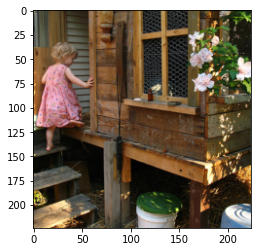

<SOS> a girl is in front of a house . <EOS>


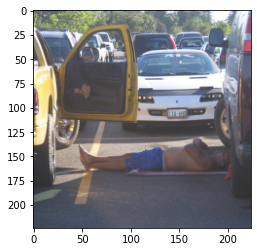

<SOS> a man is lying down and two cars . <EOS>


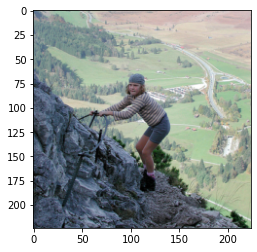

<SOS> a boy is climbing a mountain . <EOS>


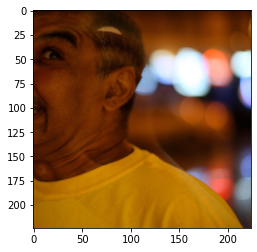

<SOS> a man in a white shirt . <EOS>


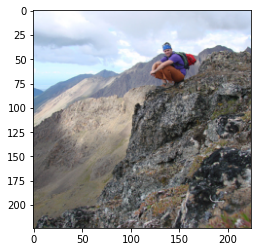

<SOS> a man is sitting on a hill . <EOS>


In [ ]:
data_get = iter(dataloader)
for i in range(5):
  model.eval()
  with torch.no_grad():
    image, _ = next(data_get)
    feature = model.encoder(image[0:1].to(device))

    captions = model.decoder.predict(feature.unsqueeze(0), corpus = dataset.corpus)
    caption = ' '.join(captions)
    view_image(image[0])

In [ ]:
class AttentionEncoder(nn.Module):

  def __init__(self):
    super(AttentionEncoder, self).__init__()
    model = models.vgg16(pretrained = True)
    for param in model.parameters():
      param.requires_grad_(False)
    classifier = list(model.children())[:-2]
    self.model = nn.Sequential(*classifier)
  
  def forward(self, image):
    feature = self.model(image)
    feature = feature.permute(0, 2, 3, 1)
    return feature.view(feature.size(0), -1, feature.size(-1))

In [ ]:
class AttentionNetwork(nn.Module):

  def __init__(self, encoding_dim, decode_dim, attention_dim):
    super(AttentionNetwork, self).__init__()

    self.attention_dim = attention_dim
    self.weight_layer = nn.Linear(decode_dim, attention_dim)
    self.encode_layer = nn.Linear(encoding_dim, attention_dim)
    self.pool = nn.Linear(attention_dim, 1)

  def forward(self, feature, hidden_value):
    encoded_val = self.encode_layer(feature)
    weight_vec = self.weight_layer(hidden_value)

    score = torch.tanh(encoded_val + weight_vec.unsqueeze(1))
    attention_score = self.pool(score)
    attention_score = attention_score.squeeze(2)
    a = F.softmax(attention_score, dim = 1)
    weight_value = feature * a.unsqueeze(2)
    return a, weight_value.sum(dim = 1)

In [ ]:
class AttentionDecoderRNN(nn.Module):

  def __init__(self, embedding_dim, vocab_size, attention_dim, encoding_dim, decoding_dim, dropout = 0.3):
    super(AttentionRNNDecoder, self).__init__()
    self.vocab_size = vocab_size
    self.decoding_dim = decoding_dim
    self.encoding_dim = encoding_dim

    self.embed_layer = nn.Embedding(vocab_size, embedding_dim)
    self.attention_network = AttentionNetwork(encoding_dim, decoding_dim, attention_dim)
    self.hidden_state = nn.Linear(encoding_dim, decoding_dim)
    self.cell_state = nn.Linear(encoding_dim, decoding_dim)

    self.lstm_layer = nn.LSTMCell(embedding_dim + encoding_dim, decoding_dim, bias = True)

    self.fc_layer = nn.Linear(decoding_dim, vocab_size)
    self.dropout_layer = nn.Dropout(p = dropout)

  def forward(self, feature, caption):
    embeddings = self.embed_layer(caption)
    hidden_state, cell_state = self.calculate_state(feature) 
    sequence_length = len(caption[0]) - 1
    feature_count = feature.size(0)
    batch_size = caption.size(0)

    predictions = torch.zeros(batch_size, sequence_length, self.vocab_size).to(device)
    alpha_values = torch.zeros(batch_size, sequence_length, feature_count).to(device)

    for value in range(sequence_length):
      alpha_val, context = self.attention_network(feature, hidden_state)
      lstm_in = torch.cat((embeddings[:, value], context), dim = 1)
      hidden_state, cell_state = self.lstm_layer(lstm_in, (hidden_state, cell_state))

      out_val = self.fc_layer(self.dropout_layer(hidden_state))

      predictions[:, value] = out_val
      alpha_values[:, value] = alpha_val
    
    return predictions, alpha_values
  
  def calculate_state(self, value):
    mean_val = value.mean(dim = 1)
    hidden_state = self.hidden_state(mean_val)
    cell_state = self.cell_state(mean_val)
    return hidden_state, cell_state
  
  def predict(self, feature, max_sequence_length = 20, corpus = None):
    batch_size = feature.size(0)
    hidden_state, cell_state = self.calculate_state(feature)
    alpha_values = []
    captions = []

    token = torch.tensor(corpus.string_index_map['<SOS>']).view(1, -1).to(device)
    embedding = self.embed_layer(token)
    
    for x in range(max_sequence_length):
      alpha_val, context = self.attention_network(feature, hidden_state)
      alpha_values.append(alpha_val.detach().numpy())

      lstm_in = torch.cat((embedding[:, 0], context), dim = 1)
      hidden_state, cell_state = self.lstm_layer(lstm_in, (hidden_state, cell_state))
      out_val = self.fc_layer(self.dropout_layer(hidden_state)).view(batch_size, -1)

      prediction_token = out_val.argmax(dim = 1)
      captions.append(prediction_token.item())
      if corpus.index_string_map[prediction_token.item()] == "<EOS>":
        break
      embedding = self.embed_layer(prediction_token.unsqueeze(0))
    
    return [corpus.index_string_map[x] for x in captions], alpha_values

In [ ]:
class AttentionEncoderDecoder(nn.Module):
  
  def __init__(self, embedding_size, vocab_size, attention_dim, encoding_dim, decoding_dim, dropout = 0.3):
    super(AttentionEncoderDecoder, self).__init__()
    self.enc_model = AttentionEncoder()
    self.dec_model = AttentionDecoderRNN(
        embedding_size,
        vocab_size,
        attention_dim,
        encoding_dim,
        decoding_dim
    )

  def forward(self, image, caption):
    feature = self.enc_model(image)
    output = self.dec_model(feature, caption)
    return output

In [ ]:
lr = 0.0005
model = AttentionEncoderDecoder(300, corpus_size, 256, 2048, 512).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = dataset.corpus.string_index_map["<pad>"])
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
  for index, (image, caption) in enumerate(iter(dataloader)):
    image, caption = image.to(device), caption.to(device)
    optimizer.zero_grad()

    output, attention = model(image, caption)
    target = caption[:, 1:]
    loss = criterion(output.view(-1, corpus_size), target.reshape(-1))
    loss.backward()

    optimizer.step()
    if index % 25 == 0:
      print("Loss at Epoch [", epoch, "] ", int(index/len(dataloader) * 100), "%: ", loss.item())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss at Epoch [ 0 ]  0 %:  0.7181931138038635
Loss at Epoch [ 0 ]  15 %:  0.6314217448234558
Loss at Epoch [ 0 ]  31 %:  0.5842406749725342
Loss at Epoch [ 0 ]  47 %:  0.582237720489502
Loss at Epoch [ 0 ]  62 %:  0.5765488147735596
Loss at Epoch [ 0 ]  78 %:  0.5599433183670044
Loss at Epoch [ 0 ]  94 %:  0.5590237975120544
Loss at Epoch [ 1 ]  0 %:  0.5505586266517639
Loss at Epoch [ 1 ]  15 %:  0.5488203167915344
Loss at Epoch [ 1 ]  31 %:  0.550239086151123
Loss at Epoch [ 1 ]  47 %:  0.549892783164978
Loss at Epoch [ 1 ]  62 %:  0.5571813583374023
Loss at Epoch [ 1 ]  78 %:  0.5446702837944031
Loss at Epoch [ 1 ]  94 %:  0.5337752103805542
Loss at Epoch [ 2 ]  0 %:  0.5654643774032593
Loss at Epoch [ 2 ]  15 %:  0.5622315406799316
Loss at Epoch [ 2 ]  31 %:  0.5447112917900085
Loss at Epoch [ 2 ]  47 %:  0.5468178391456604
Loss at Epoch [ 2 ]  62 %:  0.5363126993179321
Loss at Epoch [ 2 ]  78 %:  0.545034646987915
Loss at Epoch [ 2 ]  94 %:  0.5435853004455566
Loss at Epoch [ 3 ] 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


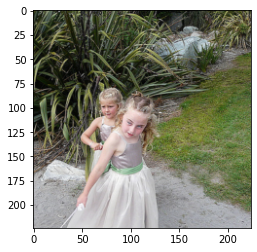

<SOS> two young girls in a park . <EOS>


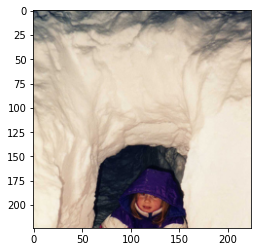

<SOS> a young boy in a hole in snow . <EOS>


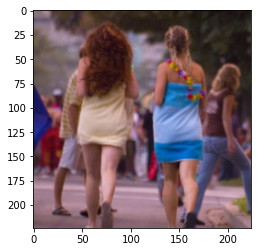

<SOS> two girls walking on the beach . <EOS>


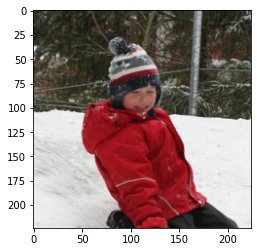

<SOS> a young boy in a red jacket is sitting on snow . <EOS>


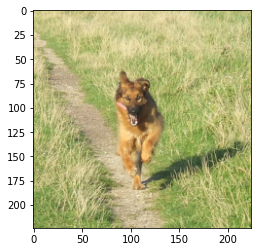

<SOS> a dog is running through a grassy field . <EOS>


In [ ]:
data_idx = iter(dataloader)
for i in range(5):
  model.eval()
  with torch.no_grad():
    image, _ = next(data_idx)
    feature = model.enc_model(image[0:1].to(device))

    captions, alphas = model.dec_model.predict(feature, vocab = dataset.corpus)
    caption = ' '.join(captions)
    view_image(image[0])
    print(caption)